In [132]:
import matplotlib.pyplot as plt
from AaltoAtoms import CircCorralData, CircCorral, clockwiseangle
from AMRL import Createc_Controller
from AMRL.Environment.get_atom_coordinate import pixel_to_nm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import ipywidgets as wdg

## Get current scan frame from STM, get atom positions, program lateral manipulation moves (in order of labeling in the figure) using GUI. 
This may require fine-tuning the parameters 'percentile' and 'edge_cutoff' in the C.get_region_centroids() call until only the surface features you want to see are registered in the image frame when you run the cell.

In [195]:
np.where(im!=0,im)

ValueError: either both or neither of x and y should be given

In [194]:
help(np.where)

Help on function where in module numpy:

where(...)
    where(condition, [x, y])
    
    Return elements chosen from `x` or `y` depending on `condition`.
    
    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.
    
    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.
    
    See Also
    --------
    choose
    nonzero : The function that is called when x and y

succeed to connect
	15 centroids


<IPython.core.display.Javascript object>


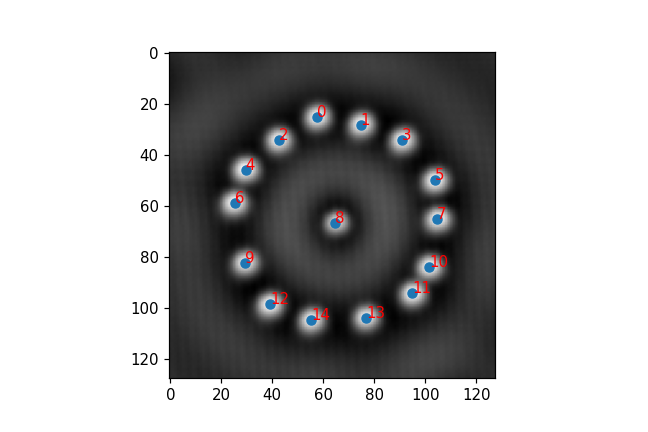

Textarea(value='[]', description='points:')

In [281]:
%matplotlib notebook

CC = Createc_Controller()

Cim = np.array(CC.stm.scandata(1,4))
zconst = float(CC.stm.getparam('ZPiezoConst'))
nmx = nmy = CC.get_len_nm()
C = CircCorral(Cim, zconst, nmx, nmy)
C.subtract_plane()
C.get_region_centroids(percentile=98, edge_cutoff=0.1, show=False)

# scale numbers between 0 and 1
# the image has to have 3 channels
# in this case we will just repeat the same channel 3 times
im = MinMaxScaler().fit_transform(Cim.flatten().reshape(-1, 1)).reshape(Cim.shape)
dispmat = np.stack([im,im,im], axis=-1)

fig = plt.figure()
plt.imshow(dispmat)

# show the atom positions
plt.scatter(*np.array(C.centroids).T)

# give numbers to atom positions
for n, c in enumerate(C.centroids):
    plt.text(*c,'%d' %(n), color='r')

# List for selected pixels
selected = []
index = 0

# Create a text area for displaying selected pixels
text_area = wdg.Textarea(
    value = str(selected),
    description = "points:",
    disabled = False
)
display(text_area)

# Function to run when a pixel is clicked
def onclick(event):
    ''' Add the clicked pixel to the list of selected pixels and
    display it as red in the image.
    '''
    global selected
    global index
    x = int(event.xdata+0.5)
    y = int(event.ydata+0.5)
    if (y, x) in selected:
        im[y,x] = C.im[y,x]
        dispmat[y,x,:] = [im[y,x], im[y,x], im[y,x]]
        selected.remove((y, x))
    else:
        dispmat[y,x,:] = [1,0,0]
        selected += [(y, x)]
    text_area.value = str(selected)  # str(dir(event))
    print(selected)
    plt.imshow(dispmat)
    plt.text(x,y,'%d' %(index), color='green')
    index += 1
    fig.canvas.draw()

ka = fig.canvas.mpl_connect('button_press_event', onclick)

### Get location of corral center
If you recieve the error "Exception: something went wrong removing central atom" you can try to change the 'percentile' parameter in the previous cell.

	Max height guess different from Gaussian fit on average by: 0.38 Å
	 2022-04-12 23:55:45.796080
	Central atom from Naive fit:  3.4783782451445324 [65.32000667 66.01896048]
	Central atom from Gauss fit:  3.491011531635528 [65.37521344 66.26334675]


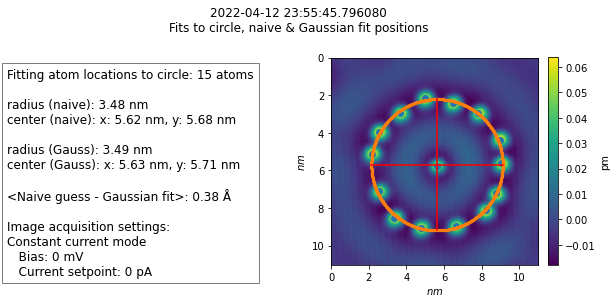

3.491011531635528

In [282]:
%matplotlib inline
C.occupied = True
C.get_corral_radius(1, savefig=False)

### Create 'perfect circle' set of data points
These have no alignment with the rest of the atoms except that the center is the same as the current corral.

Atom positions are also not lattice discretized, which becomes problematic for small corrals with dense walls. 

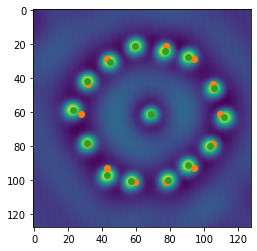

In [276]:
%matplotlib inline

n_wall_atoms = len(C.centroids) - 1
center = C.get_central_atom(C.centroids)

radius = 3.53
perfect_circle = np.array([[radius*np.cos(t), radius*np.sin(t)] for t in np.arange(0, 2*np.pi, 2*np.pi/(n_wall_atoms))])
perfect_circle = np.concatenate((perfect_circle, [[0,0]]))
perfect_circle = list(map(C.nm_to_pix, perfect_circle))
perfect_circle += np.array(center)

assert(len(perfect_circle)==len(C.centroids))

plt.imshow(C.im);
plt.scatter(*center)
plt.scatter(*(np.array(perfect_circle).T))
plt.scatter(*np.array(C.centroids).T)
plt.show()

### Rotate 'perfect circle' to minimize manipulation distance
NB: Manipulations are programmed in software by referencing pixel coordinates in current scan frame. 

If scan frame is large (or pixel size too small), then manipulations won't be as accurate. Plan accordingly.

Manipulations done via remote access cannot occur outside of the current scan frame.

Watch out for potential collisions! These are not accounted for in the cell that does the actual manipulation, so for now you need to manually interrupt the notebook before a collision happens.

zero vector


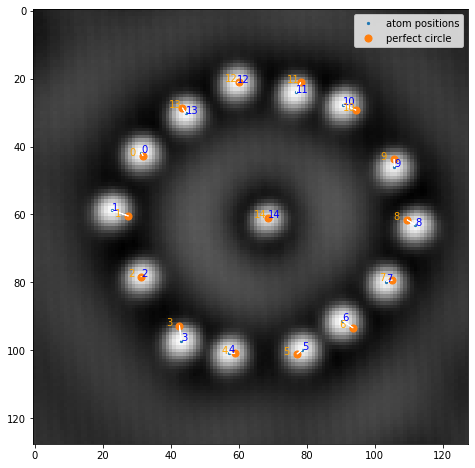

In [277]:
# Kabsch algorithm for the best rotation between two sets to minimize distance
from scipy.spatial.transform import Rotation
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
# create 3D arrays to align vectors using algorithm
# subtract the center
centroids_3D = np.array(C.centroids) - np.array(center)

# need to order centroids in same order as perfect circle to make Kabsch algo work
refvec = [1, 1]
clockwise_angle = lambda point: clockwiseangle(point, [0,0], refvec)
centroids_3D = np.array(sorted(centroids_3D, key=clockwise_angle))

perfect_circle_3D = np.array(perfect_circle) - np.array(center)

centroids_3D = np.append(centroids_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T
perfect_circle_3D = np.append(perfect_circle_3D.T, [np.zeros(len(C.centroids)).T], axis=0).T

R, rmsd_ = Rotation.align_vectors(centroids_3D, perfect_circle_3D)

applied_rotation = R.apply(perfect_circle_3D)[:,0:2].T
applied_rotation = [x + center for x in applied_rotation.T]

centroids_3D = np.array([c + center for c in centroids_3D[:,0:2]])

plt.figure(figsize=(8,8))
plt.imshow(dispmat);

plt.scatter(*np.array(centroids_3D).T, label="atom positions", s=5)
plt.scatter(*np.array(applied_rotation).T, label="perfect circle", s=50)
plt.legend()

for n,c in enumerate(centroids_3D):
    #print(*centroids_3D[:][n], applied_rotation[n])
    initial = pixel_to_nm(centroids_3D[:,][n], dispmat, offset_nm, [len_nm, len_nm])
    
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    
    dx, dy = (np.array(applied_rotation[n]) - np.array(centroids_3D[n]))
    
    plt.text(*c,'%d' %(n), color='blue')
    plt.text(*(applied_rotation[n]-[4,0]),'%d' %(n), color='orange')

    plt.arrow(*centroids_3D[n], dx, dy, color="white")
plt.show()

#np.dot(R.as_matrix(), perfect_circle_3D)

23 59 28 60


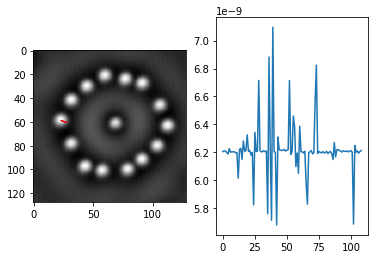

43 97 43 93


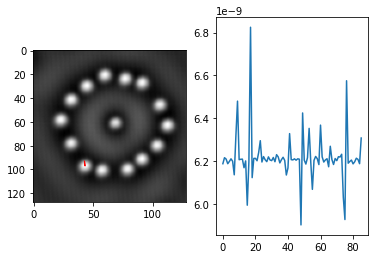

90 91 94 93


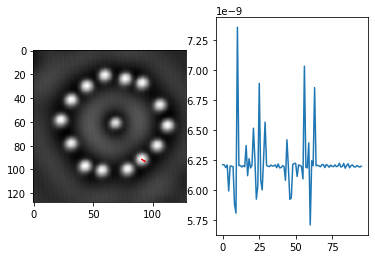

91 28 94 29


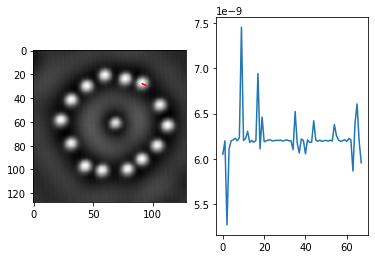

In [278]:
# set lateral manipulation parameters
latman_millivolt = 2600
latman_picoamp = 62000

# read tip offset and image size
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# bias for scanning (mV)
scan_bias_mv = 80

# for each "atom" in the image
for n in range(len(centroids_3D)):
    initial = pixel_to_nm(centroids_3D[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(applied_rotation[n]).T, dispmat[:,:,0], offset_nm, [len_nm, len_nm])

    dist_to_perfect = C.pix_to_nm(np.linalg.norm(np.array(applied_rotation[n])-np.array(centroids_3D[n])))
    if dist_to_perfect > 0.3: # nm 
        #print(centroids_3D[n], applied_rotation[n])
        im, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(dispmat);
        ax1.arrow(*centroids_3D[n], *(np.array(applied_rotation[n])-np.array(centroids_3D[n])), color='red')


        # documentation in AMRL/Environment/createc_control.py
        latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
        ax2.plot(latmandata.current)
        plt.show()
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()
# todo: plot and save data from these manipulations 

### Show atom positions from scan frame and programmed lateral manipulations. 
If they are wrong, run GUI notebook cell again and program lateral manipulations again using GUI.

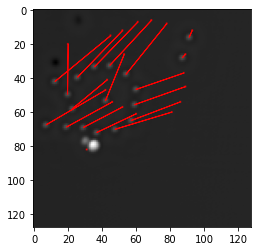

In [164]:
%matplotlib inline
#assert(len(selected)==len(C.centroids))
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()
selected1 = selected
centroids = C.centroids

for n, c in enumerate(C.centroids[0:-1]):
    plt.arrow(*c, *(np.array(list(reversed(selected1[n])))-np.array(c)), color="r")
plt.imshow(dispmat);
plt.show()
#

## Carry out lateral manipulations in order 

[91.2, 16.0] [93, 12]


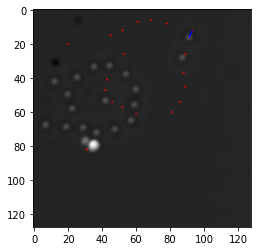

91 16 93 12
[87.2, 28.0] [89, 26]


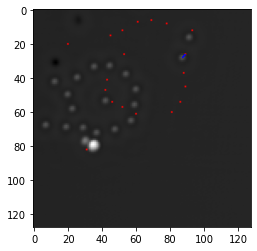

87 28 89 26
[44.5, 32.5] [69, 6]


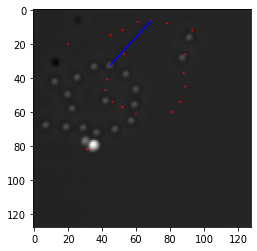

44 32 69 6
[35.45454545454545, 33.36363636363637] [61, 7]


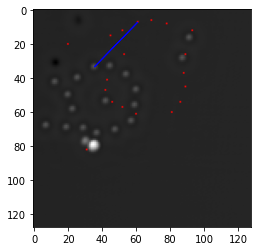

35 33 61 7
[54.0, 37.8] [78, 8]


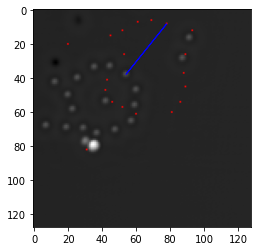

54 38 78 8
[25.5, 39.5] [52, 12]


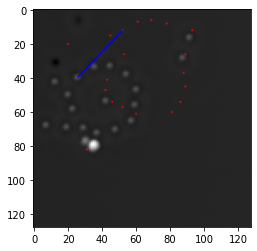

26 40 52 12
[12.2, 42.0] [45, 15]


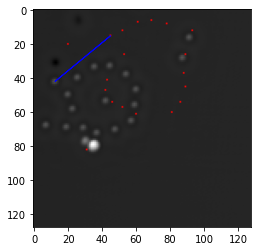

12 42 45 15
[59.888888888888886, 46.666666666666664] [88, 37]


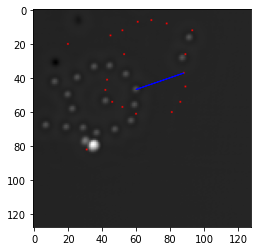

60 47 88 37
[19.636363636363637, 49.54545454545455] [20, 20]


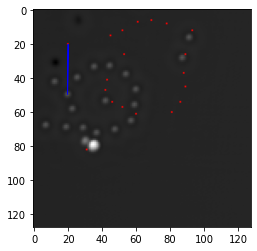

20 50 20 20
[42.0, 53.2] [53, 26]


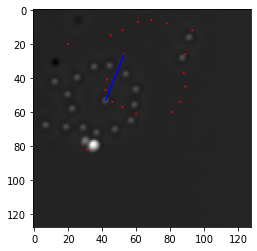

42 53 53 26
[59.09090909090909, 55.63636363636363] [89, 45]


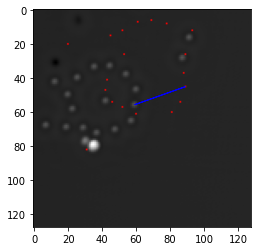

59 56 89 45
[22.5, 58.0] [43, 41]


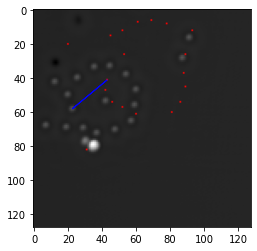

22 58 43 41
[57.0, 65.0] [86, 54]


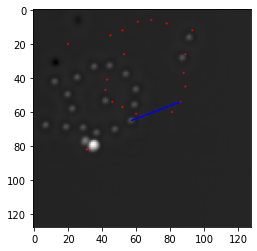

57 65 86 54
[7.0, 67.5] [42, 47]


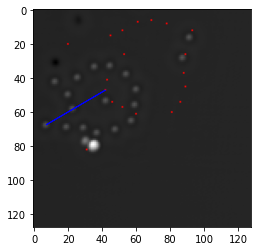

7 68 42 47
[19.0, 68.8] [46, 54]


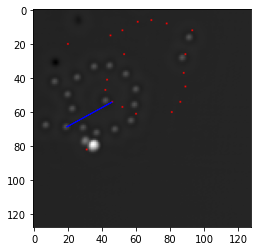

19 69 46 54
[29.0, 69.0] [52, 57]


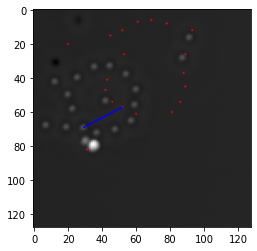

29 69 52 57
[47.63636363636363, 70.0909090909091] [81, 60]


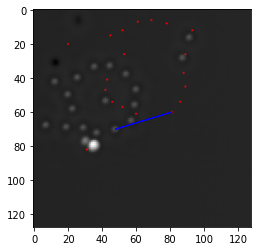

48 70 81 60
[36.8, 72.0] [60, 61]


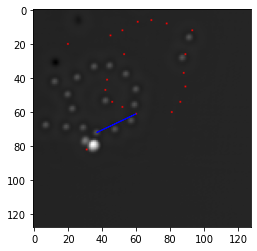

37 72 60 61


In [165]:
# set the lateral manipulation parameters
latman_millivolt = 2600
latman_picoamp = 60000
offset_nm = CC.get_xy_nm()
len_nm = CC.get_len_nm()

# for each "atom" in the image
for n in range(len(centroids[0:-1])):
    print(centroids[n], list(reversed(selected1[n])))
    initial = pixel_to_nm(centroids[n], dispmat, offset_nm, [len_nm, len_nm])
    final = pixel_to_nm(np.array(list(reversed(selected1[n]))), dispmat[:,:,0], offset_nm, [len_nm, len_nm])
    plt.imshow(dispmat);
    plt.arrow(*centroids[n], *(np.array(list(reversed(selected[n])))-np.array(centroids[n])), color="blue")
    plt.show()
    
    # see documentation in AMRL/Environment/createc_control.py
    latmandata = CC.lat_manipulation(*initial, *final, latman_millivolt, latman_picoamp, offset_nm, nmx)
    
CC.ramp_bias_mV(scan_bias_mv)
CC.stm.scanstart()

In [46]:
latmandata.current

((-5.989805984540908e-09,),
 (-6.009425845832084e-09,),
 (-6.002574881591727e-09,),
 (-6.061551260927445e-09,),
 (-6.024415633021363e-09,),
 (-6.006525943291763e-09,),
 (-5.982178752361733e-09,),
 (-6.0235723076118575e-09,),
 (-6.090581816664553e-09,),
 (-5.984663431490844e-09,),
 (-6.059562185356526e-09,),
 (-5.966172889060317e-09,),
 (-6.019069687113188e-09,),
 (-6.126953167040483e-09,),
 (-5.898089572298204e-09,),
 (-6.085890902340907e-09,),
 (-6.088050952257618e-09,),
 (-6.1973786102953454e-09,),
 (-6.11594375143909e-09,),
 (-5.931686697380201e-09,),
 (-5.99672977941168e-09,),
 (-6.055230539203649e-09,),
 (-6.082106374094565e-09,),
 (-5.9859659451433345e-09,),
 (-5.946782621890634e-09,),
 (-6.044019951190194e-09,),
 (-5.973072703113758e-09,),
 (-6.0666995871372364e-09,),
 (-6.0714415717200154e-09,),
 (-5.915329559513793e-09,),
 (-6.02619998346654e-09,),
 (-6.068807234527185e-09,),
 (-5.986148909897793e-09,),
 (-6.030084875874309e-09,),
 (-6.008238351284945e-09,),
 (-6.0526934575477

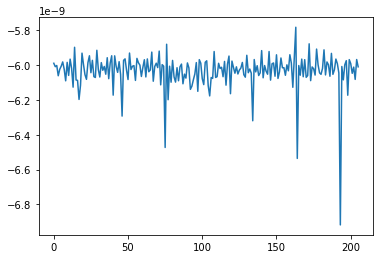

In [47]:
# the units of this is unknown ? 
plt.plot(latmandata.current)